# Tarea 2 - Regresion Polinomial & Feature engineering

### Parte 1 - Modelo exponencial de covid-19 usando feature-eng

Usando el ejemplo de covid-19 en el notebook de feature-eng (https://colab.research.google.com/drive/1sJV2HG7tQgCGKES3-dIclzHQJ9qAWB3b?usp=sharing) crear un modelo de covid-19 para Guatemala.

* Convertir la fecha a un entero "número de día", por ejemplo si se usan datos desde el 22 de abril, este es el día 0, el 23 es el día 1.
* Aplicar regresión lineal sobre la variable "Confirmed" transformada.
* Una vez entrenado el modelo usarlo para aproximar la cantidad de casos confirmados para el 6 de Junio. Se debe reportar la cantidad de casos, no la cantidad transformada obtenida.

In [379]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import datetime, os
import math

if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()

### Carga de datos

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


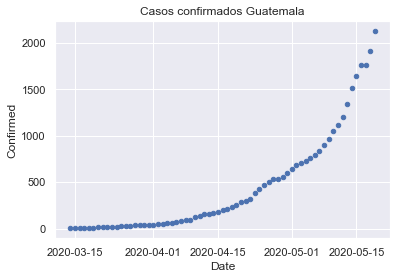

In [380]:
covid_data = pd.read_csv('covid_19_clean_complete.csv')
covid_data["Date"] = pd.to_datetime(covid_data["Date"],infer_datetime_format = True)
covid_data.head()

GT_confirmed = covid_data[(covid_data["Country/Region"] == 'Guatemala') & (covid_data["Confirmed"] > 0)].copy()
GT_confirmed.plot.scatter(x = "Date",y="Confirmed", title='Casos confirmados Guatemala')

Aplicamos logaritmo natural a los datos para obtener algo más parecido a un comportamiento lineal

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


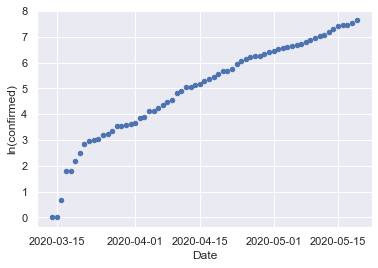

In [381]:
GT_confirmed["ln(confirmed)"] = np.log(GT_confirmed["Confirmed"])
GT_confirmed.plot.scatter(x = "Date",y="ln(confirmed)")

Removemos los datos de los días previos al 23 de marzo, donde la tendencia lineal todavía no aparece claramente, para evitar ruido en el modelo. También convertimos la fecha al número de días desde el 22 de marzo.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


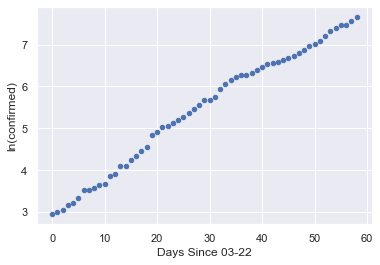

In [382]:
GT_confirmed_post24 = GT_confirmed.copy()[GT_confirmed.Date >= '2020-03-22']
GT_confirmed_post24["Days Since 03-22"] = np.arange(len(GT_confirmed_post24))
GT_confirmed_post24.plot.scatter(x = "Days Since 03-22",y="ln(confirmed)")

## Modelo de regresión lineal en TF (adaptado de la tarea anterior)

In [383]:
class SimpleLinearRegression:
    def __init__(self, x, y):
        # Si x es unidimensional, convertir a columna. 
        # Si x es matriz, asumir una variable por columna.
        self.x = x.reshape(-1,1) if x.ndim == 1 else x 
        self.y = y.reshape(-1, 1)
        self.weights = None
        self.error = None
        self.epochs = None 
        self.lr = None
        self.print_rate = None
        self.feed = None
        
    def train(self, epochs, lr, print_rate=200):
        self.print_rate = print_rate
        self.epochs = epochs
        self.lr = lr

        g = tf.Graph()
        with g.as_default():
            return self.__do_train()
    
    def __do_train(self):
        placeholder_x = tf.placeholder(tf.float64, self.x.shape, "x")
        placeholder_y = tf.placeholder(tf.float64, self.y.shape, "y")
        self.feed = { placeholder_x: self.x, placeholder_y: self.y }

        with tf.Session() as session:    
            (weights_op, error_op) = self.__gradient_descent(placeholder_x, placeholder_y, self.lr)
            self.before_training(session.graph, weights_op, error_op)
            session.run(tf.global_variables_initializer())

            for epoch in range(1, self.epochs + 1):
                out = session.run([weights_op, error_op], self.feed)
                self.error = out[1]
                self.weights = out[0]
                
                self.after_epoch(epoch, session)
                if math.isinf(self.error):
                    print("terminando por divergencia")
                    break

            session.close()
        return self.weights, self.error
        
    def __gradient_descent(self, x, y, lr):
        n_samples = x.shape[0]
        n_independent_vars = x.shape[1] + 1 # contando el intercepto
        with tf.name_scope("features"):
            ones = tf.ones([n_samples, 1], tf.float64)
            x = tf.concat([x, ones], axis = 1)
        
        with tf.name_scope("weights"):
            initial_weights = tf.zeros([n_independent_vars, 1], tf.float64)
            weights = tf.Variable(name="Weights", initial_value=initial_weights)
        
        with tf.name_scope("prediction"):
            y_hat = tf.matmul(x, weights)

        with tf.name_scope("calculate_error"):
            error = 1/2 * tf.reduce_mean(tf.math.square(y - y_hat))

        with tf.name_scope("update_weights"):
            gradients = tf.gradients(error, weights)
            adjustment = tf.scalar_mul(-lr, gradients[0])
            weights = tf.assign(weights, (tf.add(weights, adjustment))) 

        return (weights, error)
    
    def after_epoch(self, epoch, session):
        if epoch % self.print_rate == 0 or epoch == self.epochs:
            print("epoch:" + str(epoch) + " error: " + str(self.error))
    
    def before_training(self, graph, weights_op, error_op):
        # overridear para inicializar tensorboard, etc
        pass



## Extensión del modelo de regresión lineal que genera logs de Tensorboard

In [384]:
class MonitoredLinearRegression(SimpleLinearRegression):
    def __init__(self, x, y, log_dir):
        super().__init__(x,y)
        self.log_dir = log_dir
        self.extra_conf_str = ''
        self.writer = None
        self.error_summary = None
        self.weights_summary = None

    def train(self, epochs, lr, print_rate=200, extra_conf_str=''):
        self.extra_conf_str = extra_conf_str
        return super().train(epochs, lr, print_rate)
         
    def init_writer(self, graph):
        timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
        log_name = self.log_dir + timestamp + "_lr=" + str(self.lr) + "_epochs=" + str(self.epochs)
        log_name = log_name + '_' + self.extra_conf_str if self.extra_conf_str else log_name
        self.writer = tf.summary.FileWriter(log_name, graph)

    def init_summaries(self, error_op, weights_op):
        self.error_summary = tf.summary.scalar(name='Error', tensor=error_op)

    def before_training(self, graph, weights_op, error_op):
        super().before_training(graph, weights_op, error_op)
        os.makedirs(self.log_dir, exist_ok=True)
        self.init_writer(graph)
        self.init_summaries(error_op, weights_op)

    def after_epoch(self, epoch, session):
        super().after_epoch(epoch, session)
        self.writer.add_summary(session.run(self.error_summary, feed_dict=self.feed), epoch)
   

## Predicción de casos confirmados
A continuación se entrena el modelo definido arriba para obtener los pesos correspondientes a $m$ y $b$, luego realizamos la predicción para el 6 de junio, calculando el producto punto entre el vector de pesos y $[76, 1]$, (ya que pasaron 76 días desde el 22 de marzo), finalmente aplicamos la función exponencial, para revertir la transformación que hicimos al inicio.

In [385]:
x = GT_confirmed_post24["Days Since 03-22"].to_numpy()
y = GT_confirmed_post24["ln(confirmed)"].to_numpy()
model = SimpleLinearRegression(x, y)

weights, error = model.train(14000, 0.0015, 3000)
weights = weights.reshape(1,-1)


epoch:3000 error: 0.1323085228294766
epoch:6000 error: 0.024471669559754113
epoch:9000 error: 0.013731397621347865
epoch:12000 error: 0.012661694288829507
epoch:14000 error: 0.012568793563141563


In [386]:
def predict_confirmed_since_march_22(elapsed_days):
    return int(np.exp(np.dot(weights, np.array([elapsed_days, 1])))[0]) 

prediccion = predict_confirmed_since_march_22(76)
print("se predicen", prediccion, "casos para el 6 de junio (76 días desde el día 0)")


se predicen 11399 casos para el 6 de junio (76 días desde el día 0)


### Parte 2 - Modelo polinomial de calidad de vinos

Es permitido utilizar [sklearn.preprocessing.polynomialfeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)


### Instrucciones

1. Seleccionar y transformar(generando las combinaciones polinomiales para un polinomio de grado dos o tres a elección) las features que considere que son las mejores para predecir la calidad del vino, utilizar como minimo 2 features. Para seleccionar las features, hacer un analisis exploratorio por ejemplo(pero no limitado a ):  graficando y viendo la forma en que se comportan los datos.

 Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
 
 $[a,b,a^{2},b^{2},ab]$
 
 No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:
 
 $[1,a,b,a^{2},b^{2},ab]$
2. Una vez transformada la data aplicar regresion lineal con las features polinomiales usando Tensorflow.

Requisitos adicionales:
* Se debe agregar al notebook un screenshot del grafo de tensorboard, simplificando(usando  names , y name_scope como visto en clase).

* Se debe generar un directorio de logs de tensorboard para cada corrida/experimento , con cada directorio identificando facilmente la configuración del experimento como visto en clase, por ejemplo para un experimento con learning rate = 0.1 , y polinomio grado 2  crear un directorio: lr=0.1_polinomio_grado=2. (Agregar al notebook un screenshot de estas gráficas)

* Concluir en markdown cual es el mejor modelo para este caso basado en la comparativa entre curvas de costo/error en tensorboard.

In [387]:
import pandas as pd
import seaborn as sb
from sklearn import preprocessing
sb.set()

In [388]:
data = pd.read_csv('winequality-red.csv')

### Red Wine Quality Data

Se aplicará regresión para crear un modelo de la calidad de vino en función de características del mismo, siendo 1 el peor vino y 10 el mejor.

Variables de entrada:
1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 

Varaible a predecir: 
12. quality (puntuacion  entre 0 y 10) 



In [389]:
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Tomaremos 17 vinos aleatoriamente de la muestra (~10%) como set de prueba para probar la precisión del modelo. Para asegurar que siempre sean los mismos, generaremos un arreglo de índices y lo dejaremos hardcodeado en el notebook.

In [390]:
# originalmente generados con np.random.randint(1599, size=15), pero casi solo obtuvimos muestras con calidad 5,6 y 7, de manera que escogimos algunos con calidades más cercanas a los extremos para poder validar el desempeño al predecir vinos muy buenos o muy malos

test_indices = [18, 1262,  947,  808,  251,  562,  866, 1284, 1449, 6, 1071,  645,  787, 1338,  1521, 390, 3]


In [391]:

if len(data) == 1599: # solo una vez!
    test_data = data.iloc[test_indices]
    data = data.drop(data.index[test_indices])

print("test rows", len(test_data))
print("training rows", len(data))


test rows 17
training rows 1582


## Análisis exploratorio de datos

Buscamos valores faltantes

In [392]:
data.isnull().values.any()


False

In [393]:
data.describe().drop(['count']).T

,mean,std,min,25%,50%,75%,max
fixed acidity,8.325032,1.743514,4.60000,7.1000,7.90000,9.20000,15.90000
volatile acidity,0.527829,0.179391,0.12000,0.3900,0.52000,0.64000,1.58000
citric acid,0.271561,0.194975,0.00000,0.0900,0.26000,0.42000,1.00000
residual sugar,2.536568,1.405733,0.90000,1.9000,2.20000,2.60000,15.50000
chlorides,0.087515,0.047237,0.01200,0.0700,0.07900,0.09000,0.61100
free sulfur dioxide,15.871681,10.464934,1.00000,7.0000,14.00000,21.00000,72.00000
total sulfur dioxide,46.481037,32.931094,6.00000,22.0000,38.00000,62.00000,289.00000
density,0.996751,0.001887,0.99007,0.9956,0.99675,0.99783,1.00369
pH,3.311201,0.154676,2.74000,3.2100,3.31000,3.40000,4.01000
sulphates,0.658527,0.169838,0.33000,0.5500,0.62000,0.73000,2.00000


## Histogramas

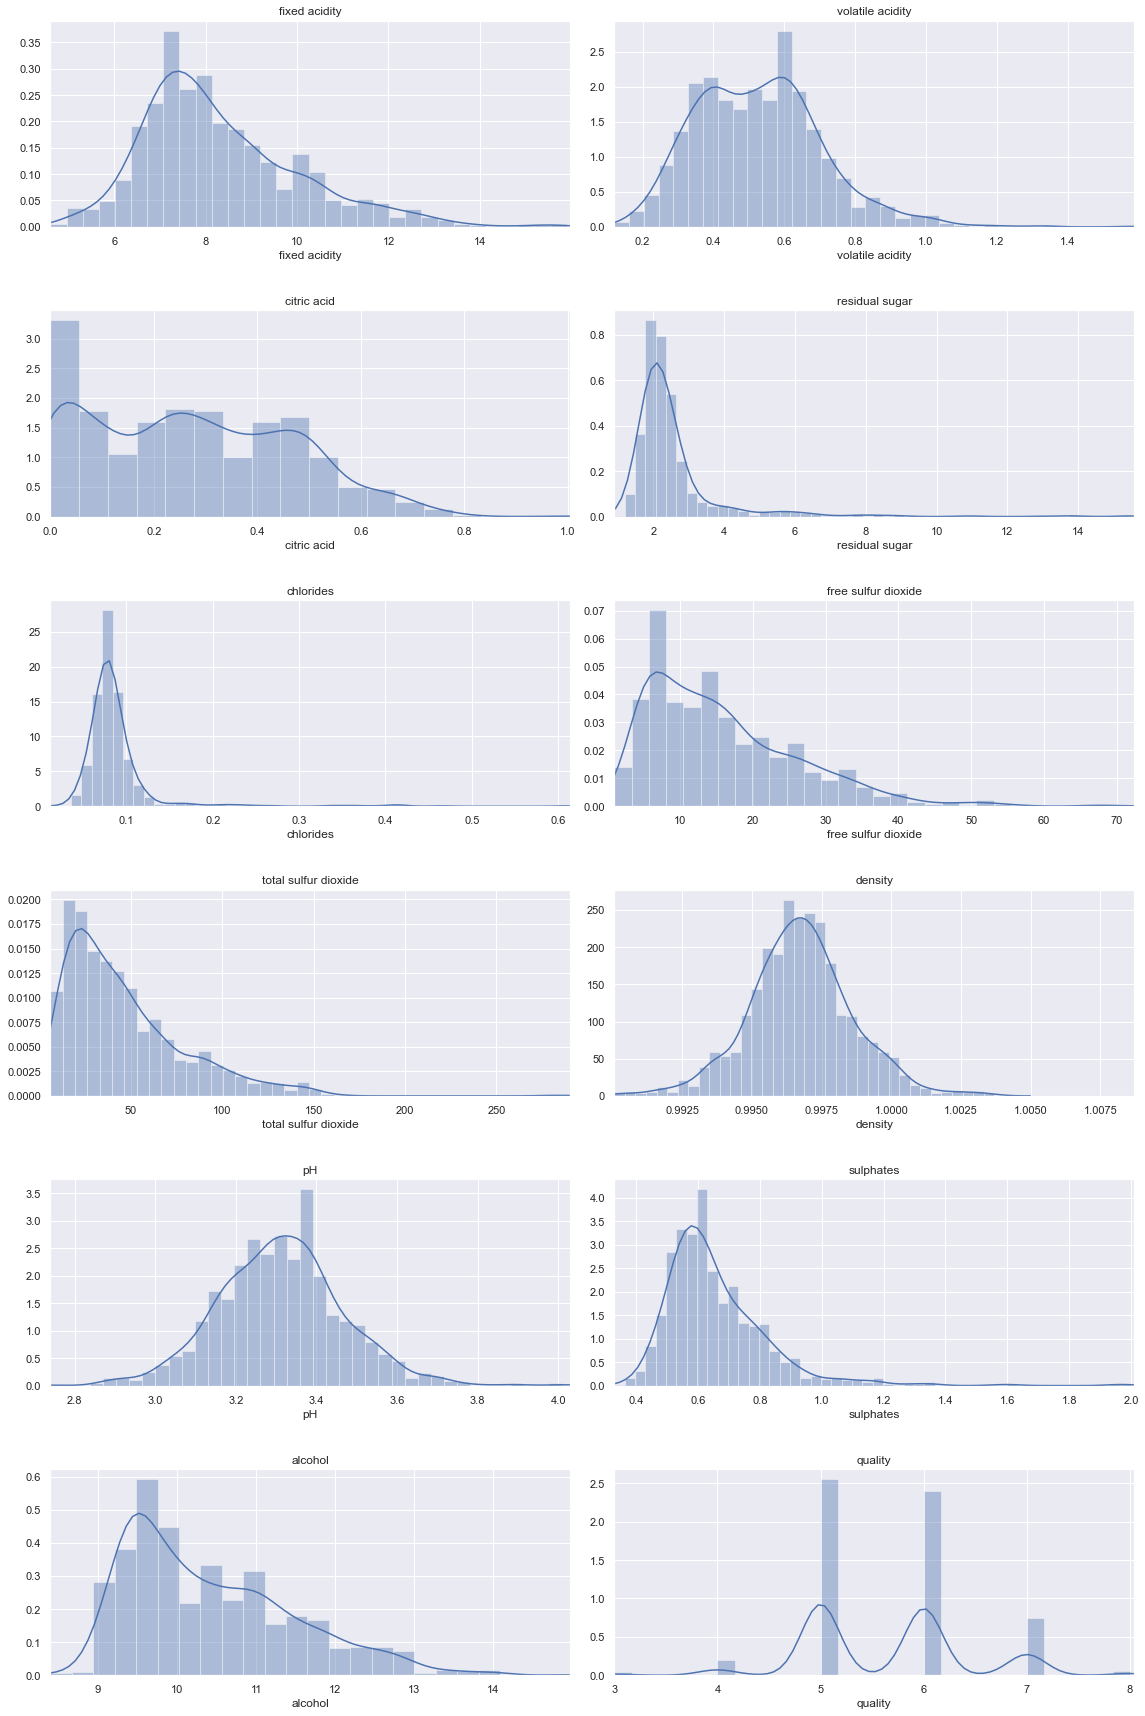

In [394]:
n = len(data.columns)
cols = 2
rows = n // cols
fig,ax = plt.subplots(rows, cols, figsize=(16,n*2))

i = 0
for col_name in data:
    current_ax = ax[i // cols][i % cols]
    current_ax.set_title(col_name)

    values = data[col_name]
    current_ax.set_xlim(np.min(values), np.max(values) * 1.005)
    sb.distplot(values,  ax=current_ax)
    i += 1

fig.tight_layout(h_pad=3)

Vemos que la mayoría de variables presentan sesgo hacia la derecha.

A continuación, exploramos la correlación entre todas las variables para ver qué nos dicen.

In [395]:
import matplotlib
colormap = matplotlib.cm.get_cmap('PiYG')
single_var_corr = data.corr()
single_var_corr.style.background_gradient(cmap=colormap, vmin=-1, vmax=1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.254865,0.670974,0.116322,0.093068,-0.158342,-0.116379,0.668247,-0.682773,0.185156,-0.060602,0.127342
volatile acidity,-0.254865,1.000000,-0.552045,-0.002578,0.061624,-0.011194,0.073818,0.021343,0.233733,-0.263893,-0.203746,-0.396727
citric acid,0.670974,-0.552045,1.000000,0.146403,0.204518,-0.065224,0.033494,0.366404,-0.540867,0.314776,0.109232,0.228723
residual sugar,0.116322,-0.002578,0.146403,1.000000,0.053778,0.187292,0.203545,0.353317,-0.084742,0.006605,0.047317,0.016481
chlorides,0.093068,0.061624,0.204518,0.053778,1.000000,0.006651,0.049024,0.198987,-0.265003,0.371808,-0.220564,-0.128090
free sulfur dioxide,-0.158342,-0.011194,-0.065224,0.187292,0.006651,1.000000,0.666434,-0.025817,0.075912,0.053661,-0.067406,-0.048422
total sulfur dioxide,-0.116379,0.073818,0.033494,0.203545,0.049024,0.666434,1.000000,0.069490,-0.064220,0.043912,-0.207160,-0.187475
density,0.668247,0.021343,0.366404,0.353317,0.198987,-0.025817,0.069490,1.000000,-0.339815,0.151542,-0.494188,-0.171531
pH,-0.682773,0.233733,-0.540867,-0.084742,-0.265003,0.075912,-0.064220,-0.339815,1.000000,-0.199489,0.204061,-0.060816
sulphates,0.185156,-0.263893,0.314776,0.006605,0.371808,0.053661,0.043912,0.151542,-0.199489,1.000000,0.089423,0.247817


**NOTA** Por alguna razón, en github no aparecen los colores aplicados para encontrar la correlación visualmente. Así es cómo debería de verse:
![image](corr.png)

* Vemos que hay varias variables independientes que presentan correlación entre ellas, pues describen atributos con cierta dependencia, por ejemplo: 
    * fixed acidity y citric acid
    * fixed acidity y density
    * fixed acidity y pH
    * total sulfur dioxide y free sulfur dioxide
* También vemos que existen variables con muy poco impacto en la calidad por sí solas, por ejemplo:
    * chlorides
    * free sulfur dioxide
    * pH
    * residual sugar?

Ahora generaremos todas las combinaciones de features de hasta grado 3, filtrando únicamente las que presenten un índice de correlación con valor absoluto mayor a 0.39, de manera que podamos seleccionar variables normales y de interacción con un potencial predictivo relativamente alto.

In [396]:
poly = preprocessing.PolynomialFeatures(3)
feature_names = data.columns[:-1].to_list()
x = data[feature_names]
y = data[['quality']]
poly_features = poly.fit_transform(x)
poly_feature_names = poly.get_feature_names(feature_names)
poly_feature_names.append('quality')

degree3_feats_and_y = np.hstack((poly_features, y))

deg3_df = pd.DataFrame(data=degree3_feats_and_y, columns=poly_feature_names)
deg3_corr = deg3_df.corr()
corr_over_39 = deg3_corr['quality'].abs()>0.39
deg3_corr[corr_over_39]['quality'].sort_values()

volatile acidity density^2   -0.398353
volatile acidity density     -0.397547
volatile acidity             -0.396727
density sulphates alcohol     0.406849
sulphates alcohol             0.408134
pH sulphates alcohol          0.411239
fixed acidity alcohol^2       0.415512
pH alcohol^2                  0.421406
alcohol^3                     0.463513
alcohol^2                     0.468541
density alcohol^2             0.469120
alcohol                       0.471309
density alcohol               0.472393
density^2 alcohol             0.473355
sulphates alcohol^2           0.489800
quality                       1.000000
Name: quality, dtype: float64

Ahora que encontramos las variables con mayor correlación, solo resta entrenar el modelo con varias, para probar cuál combinación de ellas nos provee los mejores resultados. 

## Entrenamiento de modelo con diferentes combinaciones de variables

In [397]:
tb_logs_dir = './logs/'
%load_ext tensorboard
%tensorboard --logdir {tb_logs_dir} --port=8008

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [398]:
# features de entrenamiento
sulphates        = data[['sulphates']].to_numpy().reshape(-1, 1)
alcohol          = data[['alcohol']].to_numpy().reshape(-1, 1)
density          = data[['density']].to_numpy().reshape(-1, 1)
volatile_acidity = data[['volatile acidity']].to_numpy().reshape(-1, 1)
pH               = data[['pH']].to_numpy().reshape(-1, 1)
fixed_acidity    = data[['fixed acidity']].to_numpy().reshape(-1, 1)

# estandarizar las variables independientes elegidas y entrenar modelo
def train_with_features(selected_x, epochs=12_000, lr=0.01, extra_conf_str=''):
    selected_x = np.hstack(selected_x)
    y = data[['quality']].to_numpy()

    scaler = preprocessing.StandardScaler().fit(selected_x)
    scaled_x = scaler.transform(selected_x)
    print('\n' + extra_conf_str)
    model = MonitoredLinearRegression(scaled_x, y, tb_logs_dir)
    weights, error = model.train(epochs, lr, 4000, extra_conf_str)
    return weights, scaler


In [399]:

# features del set de prueba, para validación
test_sulphates        = test_data[['sulphates']].to_numpy().reshape(-1, 1)
test_alcohol          = test_data[['alcohol']].to_numpy().reshape(-1, 1)
test_density          = test_data[['density']].to_numpy().reshape(-1, 1)
test_volatile_acidity = test_data[['volatile acidity']].to_numpy().reshape(-1, 1)
test_pH               = test_data[['pH']].to_numpy().reshape(-1, 1)
test_fixed_acidity    = test_data[['fixed acidity']].to_numpy().reshape(-1, 1)
test_quality          = test_data[['quality']].to_numpy()

# función para validar el modelo con datos de prueba
def predict_test_data(test_features, weights, scaler):
    test_features = np.hstack(test_features)
    transformed_test_x = scaler.transform(test_features)
    weights.reshape(1,-1)
    ones = np.ones((len(test_data), 1))
    transformed_test_x = np.hstack((transformed_test_x, ones))
    predicted_quality = np.dot(transformed_test_x, weights)
    table = pd.DataFrame(np.hstack((predicted_quality, test_quality)).T)
    average_error = 0.5 * np.average((predicted_quality - test_quality)**2)
    return average_error, table

In [400]:
weights, scaler = train_with_features([alcohol, volatile_acidity],\
                                     extra_conf_str='features=alcohol,volatile-acidity')

avg_error, table = predict_test_data([test_alcohol, test_volatile_acidity], weights, scaler)
print('average error: ', avg_error)
table



features=alcohol,volatile-acidity
epoch:4000 error: 0.22004175141200308
epoch:8000 error: 0.22004175141200308
epoch:12000 error: 0.22004175141200308
average error:  0.46093415119418335


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,5.110073,5.552341,6.589661,5.255732,5.372507,5.241696,5.956978,5.93236,6.111384,5.218912,4.918847,5.377797,5.490092,5.39,5.279838,5.943153,5.790969
1,4.000000,5.000000,7.000000,5.000000,6.000000,5.000000,6.000000,5.00000,8.000000,5.000000,5.000000,7.000000,6.000000,5.00,4.000000,8.000000,6.000000


In [401]:

weights, scaler = train_with_features([alcohol, volatile_acidity, density * alcohol, sulphates * alcohol**2],\
                                     extra_conf_str='features=alcohol,volatile-acidity,density*alcohol,sulphates*alcohol^2')

avg_error, table = predict_test_data([test_alcohol, test_volatile_acidity, test_density * test_alcohol, test_sulphates * test_alcohol**2], weights, scaler)
print('average error: ', avg_error)
table


features=alcohol,volatile-acidity,density*alcohol,sulphates*alcohol^2
epoch:4000 error: 0.21273697342580677
epoch:8000 error: 0.21273679757252378
epoch:12000 error: 0.21273662365779775
average error:  0.40733651750485045


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,5.048139,5.485968,6.48959,5.387158,5.413717,5.228002,6.087741,5.816842,6.159525,5.116503,4.930858,5.419026,5.424359,5.256212,5.153674,6.181568,5.693757
1,4.000000,5.000000,7.00000,5.000000,6.000000,5.000000,6.000000,5.000000,8.000000,5.000000,5.000000,7.000000,6.000000,5.000000,4.000000,8.000000,6.000000


In [402]:
weights, scaler = train_with_features([alcohol, volatile_acidity, density * alcohol, sulphates * alcohol**2, volatile_acidity * density**2],\
                                     extra_conf_str='features=alcohol,volatile-acidity,density*alcohol,sulphates*alcohol^2,volatile_acidity*density^2')

avg_error, table = predict_test_data([test_alcohol, test_volatile_acidity, test_density * test_alcohol, test_sulphates * test_alcohol**2, test_volatile_acidity * test_density**2], weights, scaler)
print('average error: ', avg_error)
table


features=alcohol,volatile-acidity,density*alcohol,sulphates*alcohol^2,volatile_acidity*density^2
epoch:4000 error: 0.2127432562807372
epoch:8000 error: 0.21274293415135828
epoch:12000 error: 0.2127426166694516
average error:  0.4072238762115385


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,5.048267,5.485952,6.489457,5.387835,5.413701,5.227672,6.088921,5.817458,6.160168,5.117054,4.929393,5.417963,5.422853,5.257801,5.154688,6.184903,5.693647
1,4.000000,5.000000,7.000000,5.000000,6.000000,5.000000,6.000000,5.000000,8.000000,5.000000,5.000000,7.000000,6.000000,5.000000,4.000000,8.000000,6.000000


In [403]:
weights, scaler = train_with_features([volatile_acidity*density, sulphates*alcohol**2],\
                                     extra_conf_str='volatile-acidity*density,sulphates*alcohol^2)')

avg_error, table = predict_test_data([test_volatile_acidity*test_density, test_sulphates*test_alcohol**2], weights, scaler)
print('average error: ', avg_error)
table


volatile-acidity*density,sulphates*alcohol^2)
epoch:4000 error: 0.22430760163131333
epoch:8000 error: 0.22430760163131339
epoch:12000 error: 0.22430760163131339
average error:  0.43788899361300043


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,5.140932,5.506245,6.226991,5.634038,5.495926,5.345246,6.116364,5.684574,6.130274,5.131631,5.037118,5.470573,5.392496,5.251406,5.203994,6.088279,5.708573
1,4.000000,5.000000,7.000000,5.000000,6.000000,5.000000,6.000000,5.000000,8.000000,5.000000,5.000000,7.000000,6.000000,5.000000,4.000000,8.000000,6.000000


In [404]:
weights, scaler = train_with_features([volatile_acidity*density**2, sulphates*alcohol**2, density**2*alcohol, density*sulphates*alcohol],\
                                     extra_conf_str='volatile_acidity*density^2,sulphates*alcohol^2,density^2*alcohol,density*sulphates*alcohol')

avg_error, table = predict_test_data([test_volatile_acidity*test_density**2, test_sulphates*test_alcohol**2, test_density**2*test_alcohol, test_density*test_sulphates*test_alcohol], weights, scaler)
print('average error: ', avg_error)
table


volatile_acidity*density^2,sulphates*alcohol^2,density^2*alcohol,density*sulphates*alcohol
epoch:4000 error: 0.21266744493085643
epoch:8000 error: 0.21250050281462143
epoch:12000 error: 0.21238567116273652
average error:  0.4074309656115832


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,5.066983,5.488705,6.485437,5.376202,5.409648,5.235817,6.087341,5.809185,6.156791,5.130738,4.939355,5.414825,5.425567,5.268227,5.176673,6.21285,5.698044
1,4.000000,5.000000,7.000000,5.000000,6.000000,5.000000,6.000000,5.000000,8.000000,5.000000,5.000000,7.000000,6.000000,5.000000,4.000000,8.00000,6.000000


In [405]:

weights, scaler = train_with_features([alcohol, volatile_acidity, density*alcohol, sulphates*alcohol**2, pH*sulphates*alcohol],\
                                     extra_conf_str='features=alcohol,volatile-acidity,density*alcohol,sulphates*alcohol^2,pH*sulphates*alcohol')

avg_error, table = predict_test_data([test_alcohol, test_volatile_acidity, test_density*test_alcohol, test_sulphates*test_alcohol**2, test_pH*test_sulphates*test_alcohol], weights, scaler)
print('average error: ', avg_error)
table


features=alcohol,volatile-acidity,density*alcohol,sulphates*alcohol^2,pH*sulphates*alcohol
epoch:4000 error: 0.2125028531059488
epoch:8000 error: 0.2122817403160004
epoch:12000 error: 0.2122137966603426
average error:  0.4102798706817672


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,5.062807,5.504854,6.502496,5.36937,5.382073,5.259307,6.066166,5.802238,6.169851,5.137483,4.956088,5.403725,5.44132,5.269128,5.174065,6.178737,5.707174
1,4.000000,5.000000,7.000000,5.00000,6.000000,5.000000,6.000000,5.000000,8.000000,5.000000,5.000000,7.000000,6.00000,5.000000,4.000000,8.000000,6.000000


## Diagrama del grafo utilizado

![graph.png](graph.png)

## Conclusiones



Al entrenar el modelo con diferentes combinaciones de variables y medir su desempeño con un set de datos de prueba, pudimos observar que la mejora obtenida en el MSE de entrenamiento al utilizar combinaciones polinomiales de variables es bastante pequeña (de un MSE=0.22 a 0.21). Pero el error de validación obtenido al comparar las predicciones con los datos de prueba disminuyó en la mayoría de pruebas 0.460 a ~0.407 al introducir combinaciones polinomiales.

Los modelos que obtuvieron el menor error de validación fueron:

`alcohol,volatile-acidity,density*alcohol,sulphates*alcohol^2` => test error: 0.40733 train error: 0.21273

`alcohol,volatile-acidity,density*alcohol,sulphates*alcohol^2,volatile_acidity*density^2`  => test error: 0.40722 train error: 0.21274


Ya que tienen desempeño muy parecido, seleccionaremos el primero porque tiene una cantidad menor de variables.

Otra observación al estudiar las predicciones del modelo, es que aunque predice bastante bien los vinos con calidad cercana a la media (calidad 5 y 6), no predice tan bien la calidad de vinos muy buenos o muy malos. Posiblemente sea porque hay muy pocos vinos con la calidad mínima y máxima en los datos de entrenamiento, además de que la calidad es al final de cuentas subjetiva y no tenemos información sobre cómo se recolectaron los datos. 

En la imagen pueden verse las gráficas de error obtenidas con las diferentes combinaciones de variables. Todas convergieron aproximadamente a la misma velocidad, pero sí se nota una reducción del error de entrenamiento al usar features polinomiales en vez de solo las dos variables independientes con mayor correlación a la calidad.
![tb-error.png](tb-error.png)
